In [1]:
!pip install torchviz

In [6]:
# importing all necessary libraries
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import random
import graphviz
import torchviz
import seaborn as sns
import time

from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [42]:
class TicTacToe:
  def __init__(self):
    self.board = np.zeros((3, 3))

  def reset(self):
    self.board = np.zeros((3, 3))
    return self.board

  def check_win(self, player):
    # Check rows
    for i in range(3):
      if np.all(self.board[i, :] == player):
        return player

    # Check columns
    for j in range(3):
      if np.all(self.board[:, j] == player):
        return player

    #Check diagonal
    if np.all(np.diag(self.board) == player):
      return player
    if np.all(np.diag(np.fliplr(self.board)) == player):
      return player


    #Check tie
    if np.all(self.board != 0):
      return -1

    return 0

  # Check for empty places on board
  def possibilities(self):
    l = []
    print(self.board)
    for i in range(len(self.board)):
        for j in range(len(self.board)):

            if self.board[i][j] == 0:
                l.append((i, j))
    return(l)

  def random_step(self, player):
    selection = self.possibilities()
    current_loc = random.choice(selection)
    self.board[current_loc] = player
    done = self.check_win(player)
    reward = 0
    if done == 2:
      reward = -1
    return self.board, reward, done

  def network_step(self, action, player):
    #print(action)
    row, col = action
    self.board[row, col] = player
    done = self.check_win(player)
    reward = 0
    if done == 1:
      reward = 1
    if done == -1:
      reward = 0.1
    return self.board, reward, done

  def network_best_move(self):
    action_mask = np.zeros((3, 3))
    for i in range(len(action_mask)):
      for j in range(len(action_mask)):
        if self.board[(i,j)] == 0:
          action_mask[i][j] = 1
    action_mask = torch.FloatTensor(action_mask.flatten())

    state = self.board.flatten()
    state = torch.FloatTensor(state).unsqueeze(0)
    probs = policy(state)


    action_probabilities = Categorical(probs * action_mask)
    action = torch.argmax(action_probabilities.probs, dim=1)

    self.board[tensor_to_tuple[action.item()]] = 1
    done = self.check_win(1)

    return self.board, done



In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(9, 256),
            nn.ReLU(),
            nn.Linear(256, 9),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
tensor_to_tuple = {}
for i in range(9):
  tensor_to_tuple[i] = (i//3, i%3)
print(tensor_to_tuple)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}


In [5]:
#Tic Tac Toe version
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    discounted_reward = 0
    i = 0
    for reward in reversed(rewards):
        discounted_reward = reward + gamma * discounted_reward
        discounted_rewards.insert(0, discounted_reward)
        #print(i," discounted_rewards: ", discounted_rewards)
        i += 1
    discounted_rewards = torch.tensor(discounted_rewards)

    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-6)
    # print("discounted rewards: ", discounted_rewards)
    # print("discounted rewards mean: ", discounted_rewards.mean())
    # print("discounted rewards std: ", discounted_rewards.std())

    return discounted_rewards

#%%debug
debug = False

def train(env, policy, optimizer, episodes=50):

  i = 0
  games_won = 0
  games_lost = 0
  games_skipped = 0
  for episode in range(episodes):
    print("trajectory: ", episode)
    state = env.reset()
    log_probs = []
    rewards = []


    done = 0
    not_done_counter = 0
    while done == 0:
        print(state)

        action_mask = np.zeros((3, 3))
        for i in range(len(action_mask)):
          for j in range(len(action_mask)):
            if state[(i,j)] == 0:
              action_mask[i][j] = 1
        action_mask = torch.FloatTensor(action_mask.flatten())

        state = torch.FloatTensor(state.flatten()).unsqueeze(0)
        if debug:
          print("inner episode loop ", not_done_counter, " state: ", state)

        probs = policy(state)
        if debug:
          print("inner episode loop ", not_done_counter, " probs: ", probs)

        action_probabilities = Categorical(probs * action_mask)
        if debug:
          print("inner episode loop ", not_done_counter, " action_probabilities: ", action_probabilities)

        action = action_probabilities.sample()

        if debug:
          print("inner episode loop ", not_done_counter, "step input action.item(): ", action.item())
          print("")
          print("")
          print("")

        state, reward, done = env.network_step(tensor_to_tuple[action.item()], player = 1)

        #Only generate random move is state is not terminal
        if done == 0:
          state, reward, done = env.random_step(player = 2)
        if debug:
          print("inner episode loop after step ", not_done_counter)
          print("step output state: \n", state)
          print("step output reward: ", reward)
          print("step output done: ", done)
          print("")
          print("")
          print("")



        log_probs.append(action_probabilities.log_prob(action))
        rewards.append(reward)

        # Inside the train function, after an episode ends:
        if done != 0:
          i += 1
          print(state)
          print("DONE!!! ", done)
          if sum(rewards) == 1:
            games_won += 1
          elif sum(rewards) == -1:
            games_lost += 1
          episode_rewards.append(sum(rewards))
          discounted_rewards = compute_discounted_rewards(rewards)

          policy_loss = []
          for log_prob, Gt in zip(log_probs, discounted_rewards):
              policy_loss.append(-log_prob * Gt)
          optimizer.zero_grad()
          policy_loss = torch.cat(policy_loss).sum()
          policy_loss.backward()
          optimizer.step()
          episode_losses.append(policy_loss.item())


          if (episode+1) % 50 == 0:
              print(f"Episode {episode}, Total Reward: {sum(rewards)}")
              print("games_won: ", games_won)
              print("games lost: ", games_lost)
              print("games_skipped: ", games_skipped)
              print("")
              print("")
              print("")

          break



In [ ]:
#Globals
episode_rewards = []
episode_losses = []

#Driver code for training the model
my_env = TicTacToe()
print("")
policy = PolicyNetwork()
print("Policy: ", policy)
total_params = sum(p.numel() for p in policy.parameters())
print(f"Number of parameters: {total_params}")
optimizer = optim.Adam(policy.parameters(), lr=1e-6)

#train(env, policy, optimizer)
train(my_env, policy, optimizer)


Policy:  PolicyNetwork(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=9, bias=True)
    (3): Softmax(dim=-1)
  )
)
Number of parameters: 4873
trajectory:  0
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
[[0. 2. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
[[0. 2. 1.]
 [0. 0. 0.]
 [0. 1. 0.]]
[[0. 2. 1.]
 [0. 0. 2.]
 [0. 1. 0.]]
[[1. 2. 1.]
 [0. 0. 2.]
 [0. 1. 0.]]
[[1. 2. 1.]
 [0. 0. 2.]
 [0. 1. 2.]]
[[1. 2. 1.]
 [0. 0. 2.]
 [1. 1. 2.]]
[[1. 2. 1.]
 [2. 0. 2.]
 [1. 1. 2.]]
[[1. 2. 1.]
 [2. 1. 2.]
 [1. 1. 2.]]
DONE!!!  1
trajectory:  1
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 2.]
 [1. 0. 1.]]
[[0. 0. 0.]
 [0. 2. 2.]
 [1. 0. 1.]]
[[1. 0. 0.]
 [0. 2. 2.]
 [1. 0. 1.]]
[[1. 0. 2.]
 [0. 2. 2.]
 [1. 0. 1.]]
[[1. 1. 2.]
 [0. 2. 2.]
 [1. 0. 1.]]
[[1. 1. 2.]
 [2. 2. 2.]
 [1. 0. 1.]]
DONE!!!  2
trajec

In [ ]:
# prompt: offload a network policy using torch.save()

# Save the trained policy network
torch.save(policy.state_dict(), '/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Deep Q Learning/policy_network.pth')

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MessageError: Error: credential propagation was unsuccessful

In [9]:
# Load a torch model I saved from colab

# Load the saved model
policy = PolicyNetwork()
policy.load_state_dict(torch.load('/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Deep Q Learning/policy_network.pth'))
policy.eval() # Set the model to evaluation mode


<ipython-input-9-0f44e8172508>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load('/content/drive/MyDrive/Monarch/RL/Tic Tac Toe/Deep Q Learn

PolicyNetwork(
  (fc): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=9, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [ ]:
from torchviz import make_dot

one_one = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0]])
X = torch.FloatTensor(one_one)


y = policy(X)
print(y)
# make_dot(y.mean(), params=dict(policy.named_parameters()), show_attrs=True, show_saved=True)

In [ ]:
parameters_0 = policy.fc[0].weight.detach().numpy()
sns.heatmap(parameters_0, annot=True)




In [ ]:
parameters_2 = policy.fc[2].weight.detach().numpy()
sns.heatmap(parameters_2, annot=True)


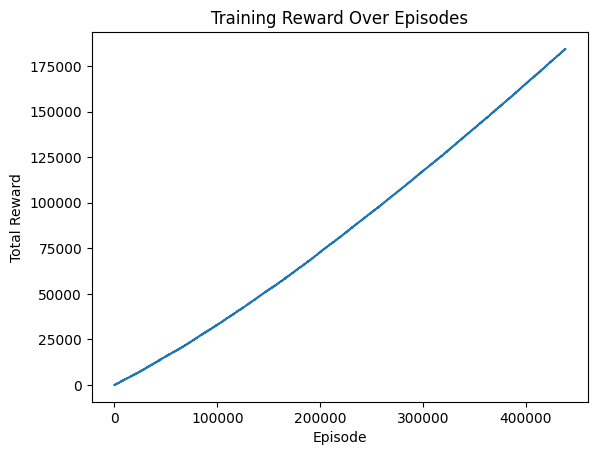

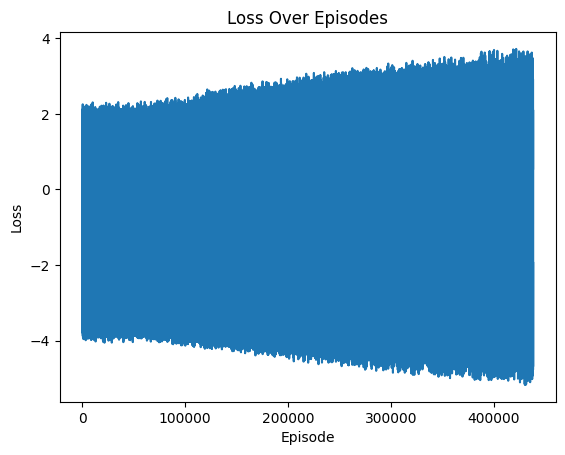

In [ ]:
cumulative_episode_rewards = []
cumulative_episodes_loss = []
for i in range(len(episode_rewards)):
  if i == 0:
    cumulative_episode_rewards.append(episode_rewards[i])
    cumulative_episodes_loss.append(episode_losses[i])
  else:
    cumulative_episode_rewards.append(cumulative_episode_rewards[i-1] + episode_rewards[i])
    cumulative_episodes_loss.append(cumulative_episodes_loss[i-1] - episode_losses[i])
    # if i > 400 and i < 500:
    #   print(i, ": ", cumulative_episode_rewards[i])


plt.plot(cumulative_episode_rewards)
plt.title('Training Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


plt.plot(episode_losses)
plt.title('Loss Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()

In [10]:
empty_board = np.zeros((3, 3))

# Creates an empty board
def create_board():
    return(np.array([[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]))

def possibilities(board):
    l = []
    for i in range(len(board)):
        for j in range(len(board)):

            if board[i][j] == 0:
                l.append((i, j))
    return(l)

# Check for empty places on board
def valid_state(board, potential_action):
  valid_moves = []
  for i in range(len(board)):
    for j in range(len(board)):
      if board[i][j] == 0:
        valid_moves.append((i, j))
  if potential_action in valid_moves:
      return True
  else:
      return False

def network_best_move(board):
  state = board.flatten()
  state = torch.FloatTensor(state).unsqueeze(0)
  probs = policy(state)

  action_mask = torch.zeros_like(probs)
  for i in range(len(action_mask[0])): # Iterate through the actions in the mask
    if valid_state(board, tensor_to_tuple[i]):
      action_mask[0][i] = 1 # Apply mask to the specific action

  action_probabilities = Categorical(probs * action_mask)
  action = torch.argmax(action_probabilities.probs, dim=1)

  board[tensor_to_tuple[action.item()]] = 1
  return board

def random_place(board):
    selection = possibilities(board)
    current_loc = random.choice(selection)
    board[current_loc] = 2
    return board

def check_win(board):
    # Check rows
    for player in [1,2]:
      for i in range(3):
        if np.all(board[i, :] == player):
          return player

      # Check columns
      for j in range(3):
        if np.all(board[:, j] == player):
          return player

      #Check diagonal
      if np.all(np.diag(board) == player):
        return player
      if np.all(np.diag(np.fliplr(board)) == player):
        return player

    #Check tie
    if np.all(board != 0):
      return -1

    return 0




In [41]:
#Experiments to verify Deep Q learning actually works
#Testing agent against random moves, ideally the agent would win ~99% of games
#Is the win percentage affected if agent is player 1 or player 2?
#function for agent as player 1
def player1_agent_vs_random_moves(test_env):

  board, winner, counter = test_env.reset(), 0, 1
  print(board)

  player1 = 1
  player2 = 2
  reward = 0
  while winner == 0:
      for player in [player1, player2]:
        if player == 1:
          board, winner = test_env.network_best_move()
          print("Board after " + str(counter) + " move")
          print(board)
          counter += 1

        if player == 2:
          board, reward, winner  = test_env.random_step(player2)
          print("Board after " + str(counter) + " move")
          print(board)
          counter += 1

        if winner != 0:
            break
  print("Winner: ", winner)
  return winner



In [43]:
n = 10000
agent_win_counter = 0
agent_loss_counter = 0
agent_tie_counter = 0

test_env = TicTacToe()
policy.eval()

start_player_1_agent = time.time()
for i in range(n):
  winner = player1_agent_vs_random_moves(test_env)
  if winner == 1:
    agent_win_counter += 1
  elif winner == 2:
    agent_loss_counter += 1
  else:
    agent_tie_counter += 1
end_player_1_agent = time.time()

print("Trials took " + str(end_player_1_agent-start_player_1_agent) + " seconds")
print(str(agent_win_counter) + " wins out of " + str(n) + " trials")

print("win percentage: ", (agent_win_counter/n)*100,"%")
print("tie percentage: ", (agent_tie_counter/n)*100,"%")
print("lose percentage: ", (agent_loss_counter/n)*100,"%")

Streaming output truncated to the last 5000 lines.
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 2. 0.]]
Board after 3 move
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 2. 1.]]
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 2. 1.]]
Board after 4 move
[[0. 0. 0.]
 [0. 1. 0.]
 [2. 2. 1.]]
Board after 5 move
[[1. 0. 0.]
 [0. 1. 0.]
 [2. 2. 1.]]
Winner:  1
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Board after 1 move
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
Board after 2 move
[[2. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
Board after 3 move
[[2. 0. 1.]
 [0. 1. 0.]
 [0. 0. 0.]]
[[2. 0. 1.]
 [0. 1. 0.]
 [0. 0. 0.]]
Board after 4 move
[[2. 0. 1.]
 [0. 1. 0.]
 [2. 0. 0.]]
Board after 5 move
[[2. 0. 1.]
 [0. 1. 0.]
 [2. 0. 1.]]
[[2. 0. 1.]
 [0. 1. 0.]
 [2. 0. 1.]]
Board after 6 move
[[2. 0. 1.]
 [0. 1. 0.]
 [2. 2. 1.]]
Board after 7 move
[[2. 0. 1.]
 [1. 1. 0.]
 [2. 2. 1.]]
[[2. 0. 1.]
 [1. 1. 0.]
 [2. 2. 1.]]
Board after 8 move
[[2. 0. 1.]
 [1. 1. 2.]
 [2. 2. 1.]]
Board after 9 move
[[2. 1. 1.]
 [1. 1. 2.]
 [2. 2. 1.]]
Winner: